<a href="https://colab.research.google.com/github/f-annassiri/BsAtlas/blob/main/BsAtlasv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setting Up the Environment and Accessing Hugging Face Token for Fine-Tuning
This section installs the required Python libraries and retrieves the Hugging Face API token, preparing the environment for fine-tuning models using Unsloth within Google Colab. The installation process is optimized for speed and to avoid dependency conflicts, while the token retrieval allows secure access to the Hugging Face Hub.

In [1]:

%%capture
# Install dependencies for faster training on Colab (as of Jan 31st, 2025).  Standard `pip install unsloth` may be slower.
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton # Core dependencies for fast training, specific xformers version for compatibility.
!pip install --no-deps cut_cross_entropy unsloth_zoo # Unsloth related dependencies.
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer # NLP related dependencies.
!pip install --no-deps unsloth # Main Unsloth library.
!pip install evaluate # Evaluation metrics.
!pip install matplotlib # Plotting.
!pip install rouge_score
!pip install bert_score evaluate


In [2]:
from google.colab import userdata
# Retrieves the Hugging Face API token from Google Colab's user secrets.
# Replace 'BsAtlas' with the key you used to store your HF token in Colab.
HF_TOKEN = userdata.get('BsAtlas')

###  Preparing the ROCO Radiography Dataset for VLM Fine-Tuning
 This section loads the ROCO radiography dataset, splits it into training and testing sets, and transforms the data into a conversation format suitable for vision-language model (VLM) fine-tuning. The goal is to create a dataset where the VLM acts as an expert radiographer, describing medical images based on instructions.

In [3]:
from datasets import load_dataset
from datasets import DatasetDict

# Step 1: Load the ROCO radiography dataset.
# The "unsloth/Radiology_mini" dataset is loaded from the Hugging Face Datasets Hub.Only the "train" split is loaded initially.
dataset = load_dataset("unsloth/Radiology_mini", split="train")
#dataset = load_dataset("eltorio/ROCOv2-radiology", split="train")
print(dataset) # Print dataset information

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/610 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/79.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1978 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/327 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'image_id', 'caption', 'cui'],
    num_rows: 1978
})


This is the train data:
Dataset({
    features: ['image', 'image_id', 'caption', 'cui'],
    num_rows: 1582
})
This is the test data:
Dataset({
    features: ['image', 'image_id', 'caption', 'cui'],
    num_rows: 396
})
This is an image from the data: 


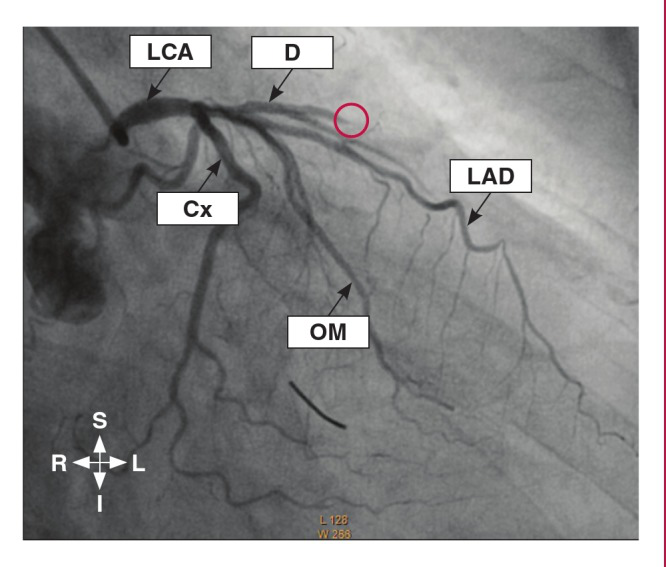

In [4]:
# Step 2: Split the dataset into training and testing sets.
# The dataset is split into 80% training data and 20% testing data,A random seed (42) is used for reproducibility.
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Access the train and test splits as independent Dataset objects.
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

# Print the train and test datasets to verify the split.
print("This is the train data:")
print(train_dataset)

print("This is the test data:")
print(test_dataset)

print("This is an image from the data: ")
train_dataset[0]["image"]


In [5]:
# Step 3: Define the conversion function to format data as a conversation.
from datasets import Dataset

# Define the instruction for the VLM. This instruction will be prepended to each image.
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

# Function to convert a single sample into the desired conversation format.
# Each sample contains an image and its corresponding caption.

def convert_to_conversation(sample):
    # Create a conversation with a user (radiographer instruction + image) and an assistant (caption).
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction}, # The instruction to the VLM.
            {"type" : "image", "image" : sample["image"]}  # The image data.
            ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["caption"]} # The expert-provided caption for the image.
            ]
        },
    ]
    return { "messages" : conversation } # Returns a dictionary with the key "messages" and the conversation list as its value.

# Convert the training dataset to the conversation format.
converted_train_dataset  = [convert_to_conversation(sample) for sample in train_dataset]

# Convert the test dataset to the conversation format.
converted_test_dataset  = [convert_to_conversation(sample) for sample in test_dataset]
# Print the first converted sample to check the format.
print(converted_train_dataset[0])


{'messages': [{'role': 'user', 'content': [{'type': 'text', 'text': 'You are an expert radiographer. Describe accurately what you see in this image.'}, {'type': 'image', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=666x567 at 0x783E997FAA90>}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': 'Coronary angiogram in the right anterior oblique view (caudal angulation) showing obstruction of the diagonal branch of the left anterior descending (LAD) artery (red ring) without collateral vessels to the distal segment of the obstructed vessel. LCA, left coronary artery; D, diagonal; Cx, circumflex; OM, obtuse marginal artery.'}]}]}


### Loading and Preparing the Llama-3.2-11B-Vision-Instruct Model with Unsloth
This section loads the Llama-3.2-11B-Vision-Instruct model using Unsloth's FastVisionModel for efficient fine-tuning. It configures the model for 4-bit quantization to reduce memory footprint and adds LoRA adapters to enable parameter-efficient fine-tuning, targeting specific layers within the model.

In [6]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# Load the Llama-3.2-11B-Vision-Instruct model using Unsloth's FastVisionModel.
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct", # The model to load from Hugging Face Hub.
    load_in_4bit = True, # Use 4-bit quantization to reduce memory usage.  Set to False for 16-bit LoRA training.
    use_gradient_checkpointing = "unsloth", # Enable gradient checkpointing to reduce memory during training
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


0it [00:00, ?it/s]

🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.2.5: Fast Mllama vision patching. Transformers: 4.48.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/375k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

In [7]:
# Add LoRA adapters for parameter-efficient fine-tuning.
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # Disable vision layer fine-tuning.
    finetune_language_layers   = True,  # Enable language layer fine-tuning.
    finetune_attention_modules = True,  # Enable attention module fine-tuning.
    finetune_mlp_modules       = True,  # Enable MLP module fine-tuning.

    r = 16,           # LoRA rank. Higher = more accuracy, more params.
    lora_alpha = 16,  # LoRA alpha, recommended >= r.
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # Disable rank-stabilized LoRA.
    loftq_config = None, # Disable LoftQ.
    # target_modules = "all-linear", # Optional, target specific layers.
)

Unsloth: Making `model.base_model.model.language_model` require gradients


### Training the Model with TRL's SFTTrainer and Unsloth's Vision Data Collator
This section configures and starts the fine-tuning process using Hugging Face TRL's SFTTrainer. It utilizes Unsloth's UnslothVisionDataCollator for proper vision-language data handling, along with optimized training parameters like batch size, learning rate, and mixed-precision training (FP16 or BF16). Gradient accumulation and other settings are configured for efficient training.

In [8]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable training!
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Unsloth Data Collator for VLM training
    train_dataset = converted_train_dataset, # Use the CONVERTED dataset here!
    eval_dataset = converted_test_dataset, # Add eval dataset
    args = SFTConfig(
        per_device_train_batch_size = 2,  # 2, Keep this at a minimal to keep usage low, play only on accumulation steps
        gradient_accumulation_steps = 8, # Increased for small batch size to simulate larger batch
        warmup_steps = 25, # More warmup with more steps
        # max_steps = 30,  # Remove max steps if using epochs
        num_train_epochs = 2,  # Train for a manageable number of epochs
        learning_rate = 1e-4,  # Optimized learning rate
        fp16 = not is_bf16_supported(),  # Best use of memory
        bf16 = is_bf16_supported(),
        logging_steps = 10,  # Increased logging
        optim = "adamw_8bit",
        weight_decay = 0.01,  # regularization, feel free to play with this!
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",# report_to = "wandb", # Best use wandb to monitor

        # MANDATORY for vision fine-tuning.
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

### Displaying GPU Memory Usage
This section retrieves and displays GPU memory statistics, including the GPU name, maximum memory capacity, and the amount of memory currently reserved. This helps monitor memory usage during training.

In [9]:
#@title Show GPU memory stats
import torch

# Get GPU properties for device 0.
gpu_stats = torch.cuda.get_device_properties(0)

# Calculate the initial GPU memory reserved (in GB).
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)

# Calculate the maximum GPU memory available (in GB).
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)

# Print the GPU name and maximum memory capacity.
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")

# Print the amount of GPU memory currently reserved.
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.557 GB.
7.584 GB of memory reserved.


### Initiating and Recording Training Statistics
This section initiates the model training process using the configured SFTTrainer and stores the resulting training statistics for later analysis.

In [10]:
# Start the training process and store the training statistics.
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1,582 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 8
\        /    Total batch size = 16 | Total steps = 196
 "-____-"     Number of trainable parameters = 52,428,800
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
10,3.397600
20,2.334900
30,1.509100
40,1.389400
50,1.261000
60,1.137300
70,1.213500
80,1.172200
90,1.154900
100,1.305200


Unsloth: Will smartly offload gradients to save VRAM!


### Displaying Final Memory and Time Statistics
After training, this section displays the final memory usage and training time statistics, providing insights into the resources consumed during the fine-tuning process. It shows the overall memory used, the memory attributed specifically to LoRA training, and the percentages of maximum GPU memory utilized.

In [11]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1982.607 seconds used for training.
33.04 minutes used for training.
Peak reserved memory = 10.611 GB.
Peak reserved memory for training = 3.027 GB.
Peak reserved memory % of max memory = 26.825 %.
Peak reserved memory for training % of max memory = 7.652 %.



### Inference: Running the Fine-Tuned Model

This section demonstrates how to run inference with the fine-tuned model. It prepares an input image and instruction, feeds them to the model, and streams the generated text output, allowing for immediate evaluation of the model's performance.


In [18]:
from unsloth import FastVisionModel
import torch
from PIL import Image  # For loading external images
from transformers import TextStreamer
from tqdm import tqdm #for progress bar

# Evaluation dataset & metrics libraries (if needed for quantitative assessment)
# import evaluate

# Enable model for inference.
FastVisionModel.for_inference(model)

# --- Function for Inference and Streaming Output ---
def run_inference(image_path, instruction):
    """
    Runs inference on a given image with a specified instruction and streams the output.

    Args:
        image_path (str): Path to the image file.
        instruction (str): The instruction for the model.
    """

    try:
        image = Image.open(image_path).convert("RGB")  # Load and convert image
    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": instruction},
            ],
        }
    ]

    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    text_streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)  # skip_special_tokens is useful

    print("Generated Output:") # Addded
    _ = model.generate(
        **inputs,
        streamer=text_streamer,
        max_new_tokens=256,
        use_cache=True,
        temperature=0.8,
        min_p=0.05,
    )
    print("\n--- End of Generation ---") # Added



# --- Example Usage with an External Image ---
external_image_path = "/test.jpg"  # Replace with your path
instruction = "You are an expert radiographer. Describe accurately what you see in this image.  Be very detailed."
run_inference(external_image_path, instruction)


# --- Example Usage with Test Dataset Image ---
instruction = "You are an expert radiographer. Describe accurately what you see in this image. Be very detailed."
image = test_dataset[12]["image"]
image.save("test_image.jpg") #saving image because the run_inference() function takes a path
run_inference("test_image.jpg", instruction)


# --- Batch Evaluation (Qualitative) ---
def evaluate_on_dataset(dataset, num_samples=10):
    """Evaluates the model on a subset of the dataset.

    Args:
        dataset: The dataset to evaluate on.
        num_samples (int): The number of samples to use for evaluation.
    """
    print("\n--- Starting Batch Evaluation ---")
    for i in tqdm(range(num_samples), desc="Evaluating Samples"): #progress bar
        image = dataset[i]["image"]
        image.save(f"temp_image_{i}.jpg") # Save image temporarily
        instruction = "You are an expert radiographer. Describe accurately what you see in this image."
        run_inference(f"temp_image_{i}.jpg", instruction)

evaluate_on_dataset(test_dataset, num_samples=5) #running only 5 samples from dataset

Generated Output:
MRI scan of brain (T2 weighted) showing right parietal lobe mass.

--- End of Generation ---
Generated Output:
Lateral radiograph of a patient with a T11 incomplete spinal cord injury. The patient underwent a T10-12 laminectomy. He had a persistent loss of function of his lower extremities, including the ability to ambulate. He was treated with a T11-12 posterior spinal fusion using three rods and six pedicle screws.

--- End of Generation ---

--- Starting Batch Evaluation ---


Evaluating Samples:   0%|          | 0/5 [00:00<?, ?it/s]

Generated Output:
Chest X-ray shows a focal area of increased opacity in the medial part of the left lung (arrowhead).


Evaluating Samples:  20%|██        | 1/5 [00:03<00:15,  3.99s/it]


--- End of Generation ---
Generated Output:
Initial anteroposterior view of left knee showing patella alta.


Evaluating Samples:  40%|████      | 2/5 [00:06<00:09,  3.30s/it]


--- End of Generation ---
Generated Output:
A 38-year-old male patient with high-grade bladder cancer and pelvic lymph node metastasis. The patient underwent pelvic lymph node dissection, and the pathology report confirmed the presence of metastatic disease.


Evaluating Samples:  60%|██████    | 3/5 [00:13<00:09,  4.78s/it]


--- End of Generation ---
Generated Output:
Axial CT scan shows a well-defined, heterogeneous, isodense soft tissue mass lesion in the left iliac fossa, compressing the bladder and uterus, and causing mass effect (white arrow). The uterus (white arrowhead) and left ovary (black arrow) are displaced anteriorly.


Evaluating Samples:  80%|████████  | 4/5 [00:23<00:06,  6.80s/it]


--- End of Generation ---
Generated Output:
Contrast study of the airway showing the tracheal stent in the trachea (arrow) and a tracheostomy tube in the right bronchus


Evaluating Samples: 100%|██████████| 5/5 [00:29<00:00,  5.82s/it]


--- End of Generation ---



### Saving and Loading Fine-Tuned LoRA Adapters and Model
This section demonstrates how to save the fine-tuned LoRA adapters and also save the full model either locally or to the Hugging Face Hub. It highlights saving only the adapter weights for efficient storage or merging the lora with the original weights, also provides options for pushing the models (adapters and tokenizer) to the Hugging Face Hub with authentication. Note that this code saves the lora adapters locally, and merges the adapters with the full model for cloud deployment.

In [13]:
# Save the LoRA adapters locally.
model.save_pretrained("BsAtlas_weights")  # Local saving for LoRA weights
tokenizer.save_pretrained("BsAtlas_tokenizer") # Save tokenizer too.

# Online saving not needed.
# # Push the LoRA adapters to the Hugging Face Hub.
# model.push_to_hub("your_name/lora_model", token = "HF_TOKEN")  # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "HF_TOKEN") # Online saving

# Push the model to hub by merging weights, needed for correct inferencing
model.push_to_hub(
  "Azzahrae96/BSAtlas", # This should be your Huggingface username / organization name
  tokenizer,
   save_method="merged_16bit", # We merge the LoRA adapters into the full model
   token=HF_TOKEN # The token for authentication to the Hugging Face Hub.
)


'model.push_to_hub(\n  "Azzahrae96/BSAtlas", # This should be your Huggingface username / organization name\n  tokenizer,\n   save_method="merged_16bit", # We merge the LoRA adapters into the full model\n   token=HF_TOKEN # The token for authentication to the Hugging Face Hub.\n)'


### Evaluating Model Performance with BLEU and ROUGE Scores
This section calculates BLEU and ROUGE scores to evaluate the performance of the fine-tuned model against the ground truth captions in the test dataset. It then generates a plot visualizing these scores to provide a clear assessment of the model's text generation quality.



1. Load the Fine-Tuned Model


Generating and Evaluating:   0%|          | 0/396 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating and Evaluating: 100%|██████████| 396/396 [34:47<00:00,  5.27s/it]


BLEU score: 0.02231163521886178
ROUGE score: 0.16025447171686852
ROUGE score: 0.03659658273982391
ROUGE score: 0.12335744134336232
BERTScore: 0.8438088035944736


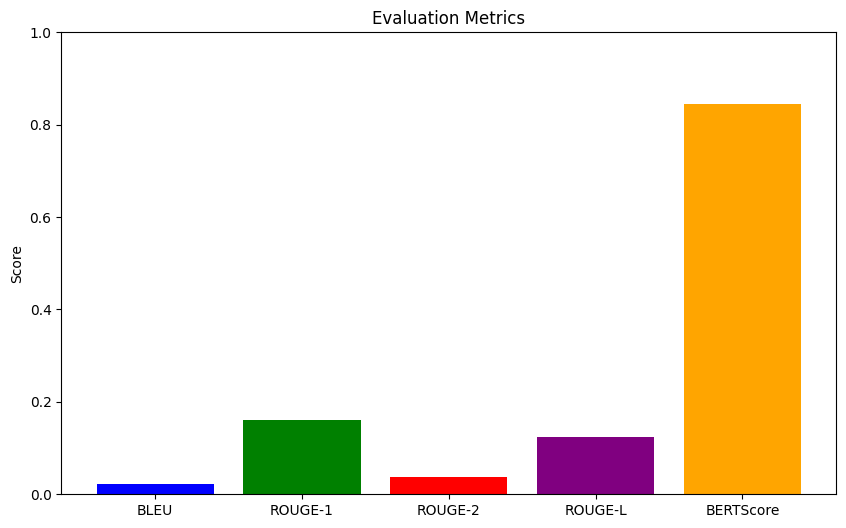

In [14]:
# Evaluation with BLEU, ROUGE, and BERTScore
import evaluate
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import numpy as np # Import numpy

# Initialize metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

# Function to generate predictions (same as before)
def generate_predictions(model, tokenizer, image, instruction, device="cuda"):
    model.eval()
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": instruction},
            ],
        }
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            **inputs, max_new_tokens=128, use_cache=True, temperature=1.0, min_p=0.05
        )

    predicted_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return predicted_text

# Prepare data for evaluation
references = []
predictions = []
bert_scores = [] # List to store bertscores

instruction = "You are an expert radiographer. Describe accurately what you see in this image."

for i in tqdm(range(len(test_dataset)), desc="Generating and Evaluating"):
    image = test_dataset[i]["image"]
    reference = test_dataset[i]["caption"]

    prediction = generate_predictions(model, tokenizer, image, instruction)

    references.append([reference])
    predictions.append(prediction)

    # Compute bertscore
    bertscore_results = bertscore.compute(predictions=[prediction], references=[reference], lang="en") # Set to english
    bert_scores.append(bertscore_results["f1"][0]) # append f1 score


# Compute metrics (same as before)
bleu_results = bleu.compute(predictions=predictions, references=references)
rouge_results = rouge.compute(predictions=predictions, references=references)

# Calculate average BERTScore
avg_bertscore = np.mean(bert_scores) # Convert to numpy array first

# Print results
print(f"BLEU score: {bleu_results['bleu']}")
print(f"ROUGE score: {rouge_results['rouge1']}")
print(f"ROUGE score: {rouge_results['rouge2']}")
print(f"ROUGE score: {rouge_results['rougeL']}")
print(f"BERTScore: {avg_bertscore}") # Prints BERTScores

# Plot results
labels = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BERTScore'] # Append bertscore
scores = [bleu_results['bleu'], rouge_results['rouge1'], rouge_results['rouge2'], rouge_results['rougeL'], avg_bertscore] # Append Bertscore

plt.figure(figsize=(10, 6)) # Increase plot width to see correctly labels
plt.bar(labels, scores, color=['blue', 'green', 'red', 'purple', 'orange']) # Appended colors for plotting
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)
plt.show()

### Expert Evaluation: Generating Captions for Manual Review
This section generates captions from the fine-tuned model for a representative subset of the test dataset. The captions, along with corresponding images and ground truth references, are exported to a CSV file suitable for review and evaluation by domain experts (e.g., radiologists).

In [17]:
import numpy as np
import pandas as pd
from tqdm import tqdm  # Import tqdm

expert_sample_size = 50

# Assume test_dataset is already loaded and defined
# Example:  test_dataset = ...

# Check if the dataset is empty
if len(test_dataset) == 0:
    print("Error: test_dataset is empty. Cannot generate captions.")
    exit()

# Inspect the dataset's structure for debugging:
print(f"Type of test_dataset: {type(test_dataset)}")
print(f"Type of test_dataset[0]: {type(test_dataset[0]) if len(test_dataset) > 0 else 'Dataset is empty'}")
if len(test_dataset) > 0:
    print(f"Keys in test_dataset[0]: {test_dataset[0].keys() if hasattr(test_dataset[0], 'keys') else 'No keys attribute'}")

random_indices = np.random.choice(len(test_dataset), size=expert_sample_size, replace=False)

predictions = []
ground_truth = []
image_list = []
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

for i in tqdm(random_indices, desc="Generating captions for expert evaluation"):
    try:
        # Convert numpy.int64 to a standard Python int
        index = int(i)  # Explicitly convert to int

        # Adapt this section based on the output of the debugging prints.
        # This is the MOST LIKELY place you'll need to modify
        # ASSUMPTION:  test_dataset[i] returns a DICTIONARY-LIKE object.
        image = test_dataset[index]["image"]  # Use the converted index
        reference = test_dataset[index]["caption"] # Use the converted index

    except (TypeError, KeyError) as e:
        print(f"Error accessing element at index {i} (original numpy.int64): {e}")
        print(f"Type of test_dataset[{i}]: {type(test_dataset[i]) if len(test_dataset)> i else 'index out of bounds'}")
        if len(test_dataset) > i:
          print(f"Contents of test_dataset[{i}]: {test_dataset[i]}") #only print if the access isn't out of bounds
        continue  # Skip to the next iteration if there's an error with this one

    # Generate the prediction
    prediction = generate_predictions(model, tokenizer, image, instruction)  # Assuming this function exists

    predictions.append(prediction)
    ground_truth.append(reference)
    image_list.append(image)

df = pd.DataFrame({
    "image": image_list,
    "reference_caption": ground_truth,
    "generated_caption": predictions
})
df.to_csv("expert_evaluation_captions.csv", index=False)

print("Captions generated. Review file (expert_evaluation_captions.csv) for expert evaluation.")

Type of test_dataset: <class 'datasets.arrow_dataset.Dataset'>
Type of test_dataset[0]: <class 'dict'>
Keys in test_dataset[0]: dict_keys(['image', 'image_id', 'caption', 'cui'])


Generating captions for expert evaluation: 100%|██████████| 50/50 [03:56<00:00,  4.73s/it]

Captions generated. Review file (expert_evaluation_captions.csv) for expert evaluation.
